# Fuel Injection Simulation

source: [cantera](https://cantera.org/examples/python/reactors/fuel_injection.py.html)

Simulation of fuel injection into a vitiated air mixture to show formation of
soot precursors.

Demonstrates the use of a user-supplied function for the mass flow rate through
a MassFlowController, and the use of the SolutionArray class to store results
during reactor network integration and use these results to generate plots.

Requires: cantera >= 2.5.0, matplotlib >= 2.0
"""


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import cantera as ct

In [2]:
# Use a reduced n-dodecane mechanism with PAH formation pathways
gas = ct.Solution('nDodecane_Reitz.yaml', 'nDodecane_IG')
gas.case_sensitive_species_names = True

# Create a Reservoir for the fuel inlet, set to pure dodecane
gas.TPX = 300, 20*ct.one_atm, 'c12h26:1.0'
inlet = ct.Reservoir(gas)

# Create Reactor and set initial contents to be products of lean combustion
gas.TP = 1000, 20*ct.one_atm
gas.set_equivalence_ratio(0.30, 'c12h26', 'n2:3.76, o2:1.0')
gas.equilibrate('TP')
r = ct.IdealGasReactor(gas)
r.volume = 0.001  # 1 liter


In [3]:
def fuel_mdot(t):
    """Create an inlet for the fuel, supplied as a Gaussian pulse"""
    total = 3.0e-3  # mass of fuel [kg]
    width = 0.5  # width of the pulse [s]
    t0 = 2.0  # time of fuel pulse peak [s]
    amplitude = total / (width * np.sqrt(2*np.pi))
    return amplitude * np.exp(-(t-t0)**2 / (2*width**2))

In [4]:
mfc = ct.MassFlowController(inlet, r, mdot=fuel_mdot)

# Create the reactor network
sim = ct.ReactorNet([r])

# Integrate for 10 seconds, storing the results for later plotting
tfinal = 10.0
tnow = 0.0
i = 0
tprev = tnow
states = ct.SolutionArray(gas, extra=['t'])

In [5]:
while tnow < tfinal:
    tnow = sim.step()
    i += 1
    # Storing results after every step can be excessive. Instead, store results
    # every 10 steps, or more frequently if large steps are being taken.
    if tnow-tprev > 1e-2 or i == 10:
        i = 0
        tprev = tnow
        states.append(r.thermo.state, t=tnow)

In [6]:
# nice names for species, including PAH species that can be considered
# as precursors to soot formation
species_aliases = {
    'o2': 'O$_2$',
    'h2o': 'H$_2$O',
    'co': 'CO',
    'co2': 'CO$_2$',
    'h2': 'H$_2$',
    'ch4': 'CH$_4$'
}
for name, alias in species_aliases.items():
    gas.add_species_alias(name, alias)

pah_aliases = {
    'A1c2h': 'phenylacetylene',
    'A1c2h3': 'styrene',
    'A1': 'benzene',
    'A2': 'naphthalene',
    'A2r5': 'acenaphthylene',
    'A3': 'phenanthrene',
    'A4': 'pyrene'
}
for name, alias in pah_aliases.items():
    gas.add_species_alias(name, alias)

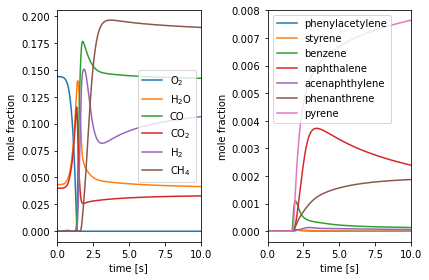

In [7]:
# Plot the concentrations of species of interest
f, ax = plt.subplots(1, 2)

for s in species_aliases.values():
    ax[0].plot(states.t, states(s).X, label=s)

for s in pah_aliases.values():
    ax[1].plot(states.t, states(s).X, label=s)

for a in ax:
    a.legend(loc='best')
    a.set_xlabel('time [s]')
    a.set_ylabel('mole fraction')
    a.set_xlim([0, tfinal])

f.tight_layout()
plt.show()